In [1]:
# Read all of the training and test scores.

import os
import os.path
import csv

def read_scores(fn):
    lines = open(fn).readlines()[1:]
    scores = []
    
    for line in lines:
        cols = line.split()
        assert(len(cols) == 2)
        scores.append({"epoch": int(cols[0]), "score": float(cols[1])})
        
    return sorted(scores, key=lambda x: x["epoch"])

def read_results(trial_dir, train_file, test_file, model_results, method_results):
    train_scores = read_scores(train_file)
    test_scores = read_scores(test_file)
    
    best_train = max(train_scores, key=lambda x: x["score"])
    best_test = max(test_scores, key=lambda x: x["score"])
    model_results.append({"method": trial_dir, "score": best_test["score"]})
    
    assert(trial_dir not in method_results)
    method_results[trial_dir] = {}
    method_results[trial_dir]["train_scores"] = train_scores
    method_results[trial_dir]["test_scores"] = test_scores
    method_results[trial_dir]["best_train"] = best_train
    method_results[trial_dir]["best_test"] = best_test

def get_accuracy_info(model_dir, desc_file):
    model_results = []
    method_results = {}
    train_scores_fn = "train_scores.csv"
    test_scores_fn = "test_scores.csv"
    
    for _, dirs, _ in os.walk(model_dir):
        for trial_dir in dirs:
            train_file = os.path.join(model_dir, trial_dir, train_scores_fn)
            test_file = os.path.join(model_dir, trial_dir, test_scores_fn)
            read_results(trial_dir, train_file, test_file, model_results, method_results)
        
    model_results = sorted(model_results, key=lambda x: x["score"])
    #method_results = sorted(method_results)
    
    method_desc = {}
    desc_reader = csv.reader(open(desc_file, 'r'), delimiter='\t', quotechar='"')
    for row in desc_reader:
        method_desc[row[0]] = row[1]
    
    return model_results, method_results, method_desc
    
model_dir_5x5 = "../models/svhn_5x5_batch_100"
model_dir_3x3 = "../models/svhn_3x3_batch_100"
desc_5x5 = "../logs/method_desc_5x5.csv"
desc_3x3 = "../logs/method_desc_3x3.csv"

model_results_5x5, method_results_5x5, method_desc_5x5 = get_accuracy_info(model_dir_5x5, desc_5x5)
model_results_3x3, method_results_3x3, method_desc_3x3 = get_accuracy_info(model_dir_3x3, desc_3x3)


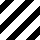
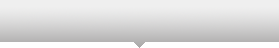
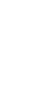
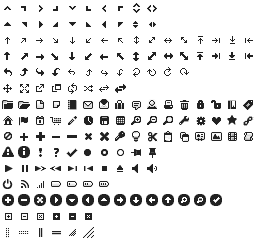
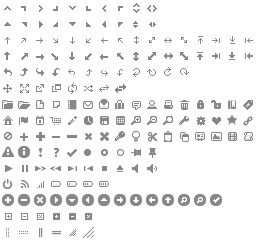
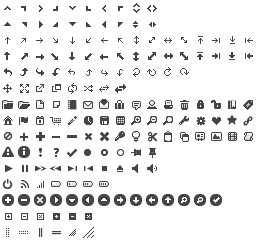
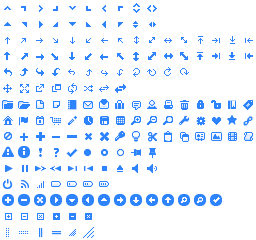
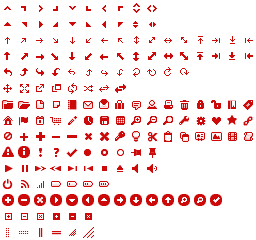
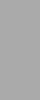
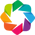
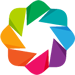
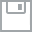
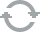
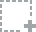
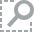
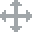
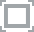
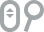

In [2]:
import bokeh.plotting as plt
plt.output_notebook()

In [46]:
# Create the line plots.

import re
import numpy as np

def add_plot(info, color, label, fig):
    epochs = [x["epoch"] for x in info["test_scores"]]
    scores = [x["score"] for x in info["test_scores"]]
    fig.line(epochs, scores, color=color, legend=label)

def make_line_plot(regex, results, desc):
    fig = plt.figure(width=320, height=300, title=regex[0:regex.rfind("_")],
        title_text_font_size='10pt')
    fig.xaxis.axis_label_text_font_size='10pt'
    fig.yaxis.axis_label_text_font_size='10pt'
    
    methods = []
    for method, info in results.items():
        if re.match(regex, method):
            methods.append({"method": method, "info": info, \
                "score": info["best_test"]["score"]})
            
    results = min(5, len(methods))
    methods = sorted(methods, key=lambda x: x["score"], reverse=True)
    
    # Obtained using http://colorbrewer2.org
    colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", \
              "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", \
              "#cab2d6", "#6a3d9a"]
    
    for item, color in zip(methods[0:results], colors[0:results]):
        add_plot(item["info"], color, desc[item["method"]], fig)
        
    fig.legend.orientation = "bottom_right"
    fig.legend.label_text_font_size = "6pt"
    return fig

In [47]:
# Validation accuracies for methods on the 5x5 model.

plots = np.array([[ \
    make_line_plot(r"sgu_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"sgu_lr_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"sgu_lr_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"sgu_lr_mom_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"adadelta_eps_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"adadelta_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"adadelta_decay_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"rmsprop_eps_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"rmsprop_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"rmsprop_decay_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"adam_eps_lambda_[0-9]+", method_results_5x5, method_desc_5x5),
    make_line_plot(r"adam_lr_beta1_beta2_[0-9]+", method_results_5x5, method_desc_5x5) \
]])

plots.resize((4, 3))
grid_plot = plt.gridplot(plots.tolist())
plt.show(grid_plot)

In [48]:
# Validation accuracies for methods on the 3x3 model.

plots = np.array([[ \
    make_line_plot(r"adadelta_eps_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"adadelta_decay_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"adadelta_decay_mom_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"rmsprop_eps_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"rmsprop_decay_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"rmsprop_decay_mom_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"adam_eps_lambda_[0-9]+", method_results_3x3, method_desc_3x3),
    make_line_plot(r"adam_lr_beta1_beta2_[0-9]+", method_results_3x3, method_desc_3x3), \
    None, None, None, None \
]])

plots.resize((4, 3))
grid_plot = plt.gridplot(plots.tolist())
plt.show(grid_plot)

In [49]:
# Epochs taken to reach a fraction f of the best validation accuracy.

def find_closest(frac, quality_dict):
    temp = [x for x in quality_dict.items() if x[0] <= frac]
    return min(temp, key=lambda x: frac - x[0])[1]

def compute_quality_info(method, info):
    quality_dict = {}
    best_test = info["best_test"]["score"]
    
    for item in info["test_scores"]:
        cur_frac = (best_test - item["score"]) / best_test
        update = True
        for frac, epochs in quality_dict.items():
            if frac <= cur_frac and epochs <= item["epoch"]:
                update = False
                quality_dict[frac] = item["epoch"]
        if update:
            quality_dict[cur_frac] = item["epoch"]
    
    dense_quality_dict = {}
    for frac in np.arange(0, 0.0301, 0.001):
        dense_quality_dict[frac] = find_closest(frac, quality_dict)
    return dense_quality_dict

def add_plot(method, info, color, label, fig):
    quality_dict = compute_quality_info(method, info)
    frac = [100 * x[0] for x in sorted(quality_dict.items())]
    epochs = [x[1] for x in sorted(quality_dict.items())]
    fig.line(frac, epochs, color=color, legend=label)

def make_quality_plot(regex, results, desc):
    fig = plt.figure(width=450, height=300, title=regex[0:regex.rfind("_")],
        title_text_font_size='10pt')
    fig.xaxis.axis_label_text_font_size='10pt'
    fig.yaxis.axis_label_text_font_size='10pt'
    
    methods = []
    for method, info in results.items():
        if re.match(regex, method):
            methods.append({"method": method, "info": info, \
                "score": info["best_test"]["score"]})
            
    results = min(5, len(methods))
    methods = sorted(methods, key=lambda x: x["score"], reverse=True)
    
    # Obtained using http://colorbrewer2.org
    colors = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", \
              "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", \
              "#cab2d6", "#6a3d9a"]
    
    for item, color in zip(methods[0:results], colors[0:results]):
        add_plot(item["method"], item["info"], color, desc[item["method"]], fig)
        
    fig.legend.orientation = "bottom_left"
    fig.legend.label_text_font_size = "6pt"
    return fig

In [50]:
# Quality plots for methods on the 5x5 model.

# Methods that display large oscillations in validation error tend to make
# sporadic, large, and sudden improvements. On the other hand, methods
# that make steady progress without oscillations in the validation error
# tend to make incremental progress at regular intervals.

# Note: we can use the quality plots to characterize the different periods
# in the optimization process. For the 5x5 model, the last 30 iterations
# are spent getting within a small fraction of the best validation accuracy.

plots = np.array([[ \
    make_quality_plot(r"sgu_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"sgu_lr_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"sgu_lr_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"sgu_lr_mom_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"adadelta_eps_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"adadelta_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"adadelta_decay_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"rmsprop_eps_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"rmsprop_decay_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"rmsprop_decay_mom_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"adam_eps_lambda_[0-9]+", method_results_5x5, method_desc_5x5),
    make_quality_plot(r"adam_lr_beta1_beta2_[0-9]+", method_results_5x5, method_desc_5x5) \
]])

plots.resize((6, 2))
grid_plot = plt.gridplot(plots.tolist())
plt.show(grid_plot)

In [51]:
# Quality plots for methods on the 3x3 model.

plots = np.array([[ \
    make_quality_plot(r"adadelta_eps_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"adadelta_decay_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"adadelta_decay_mom_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"rmsprop_eps_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"rmsprop_decay_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"rmsprop_decay_mom_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"adam_eps_lambda_[0-9]+", method_results_3x3, method_desc_3x3),
    make_quality_plot(r"adam_lr_beta1_beta2_[0-9]+", method_results_3x3, method_desc_3x3) \
]])

plots.resize((4, 2))
grid_plot = plt.gridplot(plots.tolist())
plt.show(grid_plot)

In [5]:
# Prints information about the parameter settings for each method.

import re

def print_method_info(regex, results, desc):
    data = []
    for method, info in results.items():
        if re.match(regex, method):
            data.append({"name": method, "desc": desc[method], \
                "score": info["best_test"]["score"]})
    for item in sorted(data, key=lambda x: x["score"]):
        print(item)
            
print_method_info(r"sgu_lr_mom_decay_[0-9]+", method_results_5x5, method_desc_5x5)

{'desc': 'lr = 0.2, mom = 0.999, decay = 1e-08', 'name': 'sgu_lr_mom_decay_36', 'score': 0.85852028272895}
{'desc': 'lr = 0.2, mom = 0.95, decay = 1e-08', 'name': 'sgu_lr_mom_decay_33', 'score': 0.86616472034419}
{'desc': 'lr = 0.2, mom = 0.999, decay = 1e-06', 'name': 'sgu_lr_mom_decay_35', 'score': 0.87085125998771}
{'desc': 'lr = 0.2, mom = 0.9, decay = 1e-08', 'name': 'sgu_lr_mom_decay_30', 'score': 0.87208051628765}
{'desc': 'lr = 0.01, mom = 0.95, decay = 0.0001', 'name': 'sgu_lr_mom_decay_4', 'score': 0.87296404425323}
{'desc': 'lr = 0.01, mom = 0.9, decay = 0.0001', 'name': 'sgu_lr_mom_decay_1', 'score': 0.8730024585126}
{'desc': 'lr = 0.01, mom = 0.999, decay = 0.0001', 'name': 'sgu_lr_mom_decay_7', 'score': 0.87430854333128}
{'desc': 'lr = 0.2, mom = 0.9, decay = 1e-06', 'name': 'sgu_lr_mom_decay_29', 'score': 0.87615242778119}
{'desc': 'lr = 0.01, mom = 0.95, decay = 1e-08', 'name': 'sgu_lr_mom_decay_6', 'score': 0.87914874001229}
{'desc': 'lr = 0.01, mom = 0.95, decay = 1e-

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt

def read_scores(file):
    reader = csv.reader(open(file, 'r'), delimiter='\t', quotechar='"')
    
    # Skip the header.
    next(reader, None)
    
    iters = []
    scores = []
    for row in reader:
        iters.append(100 * (int(row[0]) - 1))
        scores.append(10 * float(row[1]))
    return iters, scores

def make_violin_plots(train_scores_file, test_scores_file, log_file, width=30, vwidth=30):
    # Parse the log file.
    log_reader = csv.reader(open(log_file, 'r'), delimiter=',', \
        quotechar='"', skipinitialspace=True)

    eig_iters = []
    eig_dists = []
    loss_dists = []
    log_eig_dists = []

    iters = []
    loss_list = []
    norm_grad_list = []
    theta_list = []
    eta_a_list = []
    eta_w_list = []

    # Skip the header.
    next(log_reader, None)

    for row in log_reader:
        # Parse the scalar quantities.
        iters.append(100 * (int(row[0]) - 1) + int(row[1]))
        loss_list.append(row[2])
        norm_grad_list.append(row[3])
        theta_list.append(row[6])
        eta_a_list.append(row[7])
        eta_w_list.append(row[8])
    
        # Parse the eigenvalue and loss distributions.
        if len(row[4]) > 0:
            eig_iters.append(100 * (int(row[0]) - 1) + int(row[1]))
            eig_dists.append([float(x) for x in row[4].split(", ")])
            log_eig_dists.append([math.log(abs(float(x))) for x in row[4].split(", ")])
            loss_dists.append([float(x) for x in row[5].split(", ")])
            if len(eig_dists[-1]) != 100:
                print("Warning: dist at iter {} has length {}.".format( \
                    eig_iters[-1], len(eig_dists[-1])))
    
    # Get the accuracy data.
    train_acc_iters, train_acc_scores = read_scores(train_scores_file)
    test_acc_iters, test_acc_scores = read_scores(test_scores_file)
    
    # Create the violin plots.
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(width, 4 * 10))
    
    axes[0].violinplot(eig_dists, eig_iters, points=100, widths=vwidth,
        showmeans=False, showextrema=True, showmedians=True)

    vplots = []
    for axis in axes[1:]:
        axis.violinplot(log_eig_dists, eig_iters, points=100, widths=vwidth,
            showmeans=False, showextrema=True, showmedians=True)

    train_line, = axes[1].plot(train_acc_iters, train_acc_scores)
    test_line, = axes[1].plot(test_acc_iters, test_acc_scores)
    theta_line, = axes[1].plot(iters, theta_list)
    axes[1].legend([train_line, test_line, theta_line], ["train_acc", "test_acc", "theta"],
            loc=1, prop={"size": 16})   

    loss_line, = axes[2].plot(iters, loss_list)
    norm_grad_line, = axes[2].plot(iters, norm_grad_list)
    axes[2].legend([loss_line, norm_grad_line], ["loss", "norm_grad"], loc=1, prop={"size": 16})

    eta_a_line, = axes[3].plot(iters, eta_a_list)
    eta_w_line, = axes[3].plot(iters, eta_w_list)
    axes[3].legend([eta_a_line, eta_w_line], ["eta_a", "eta_w"], loc=1, prop={"size": 16})

    for axis in axes:
        start, end = axis.get_xlim()
        axis.set_xlabel("Iterations", size=16)
        axis.xaxis.set_ticks(np.arange(start, end, 100))
        axis.set_xlim(left=-50)
        
    return eig_iters, eig_dists, log_eig_dists, loss_dists 

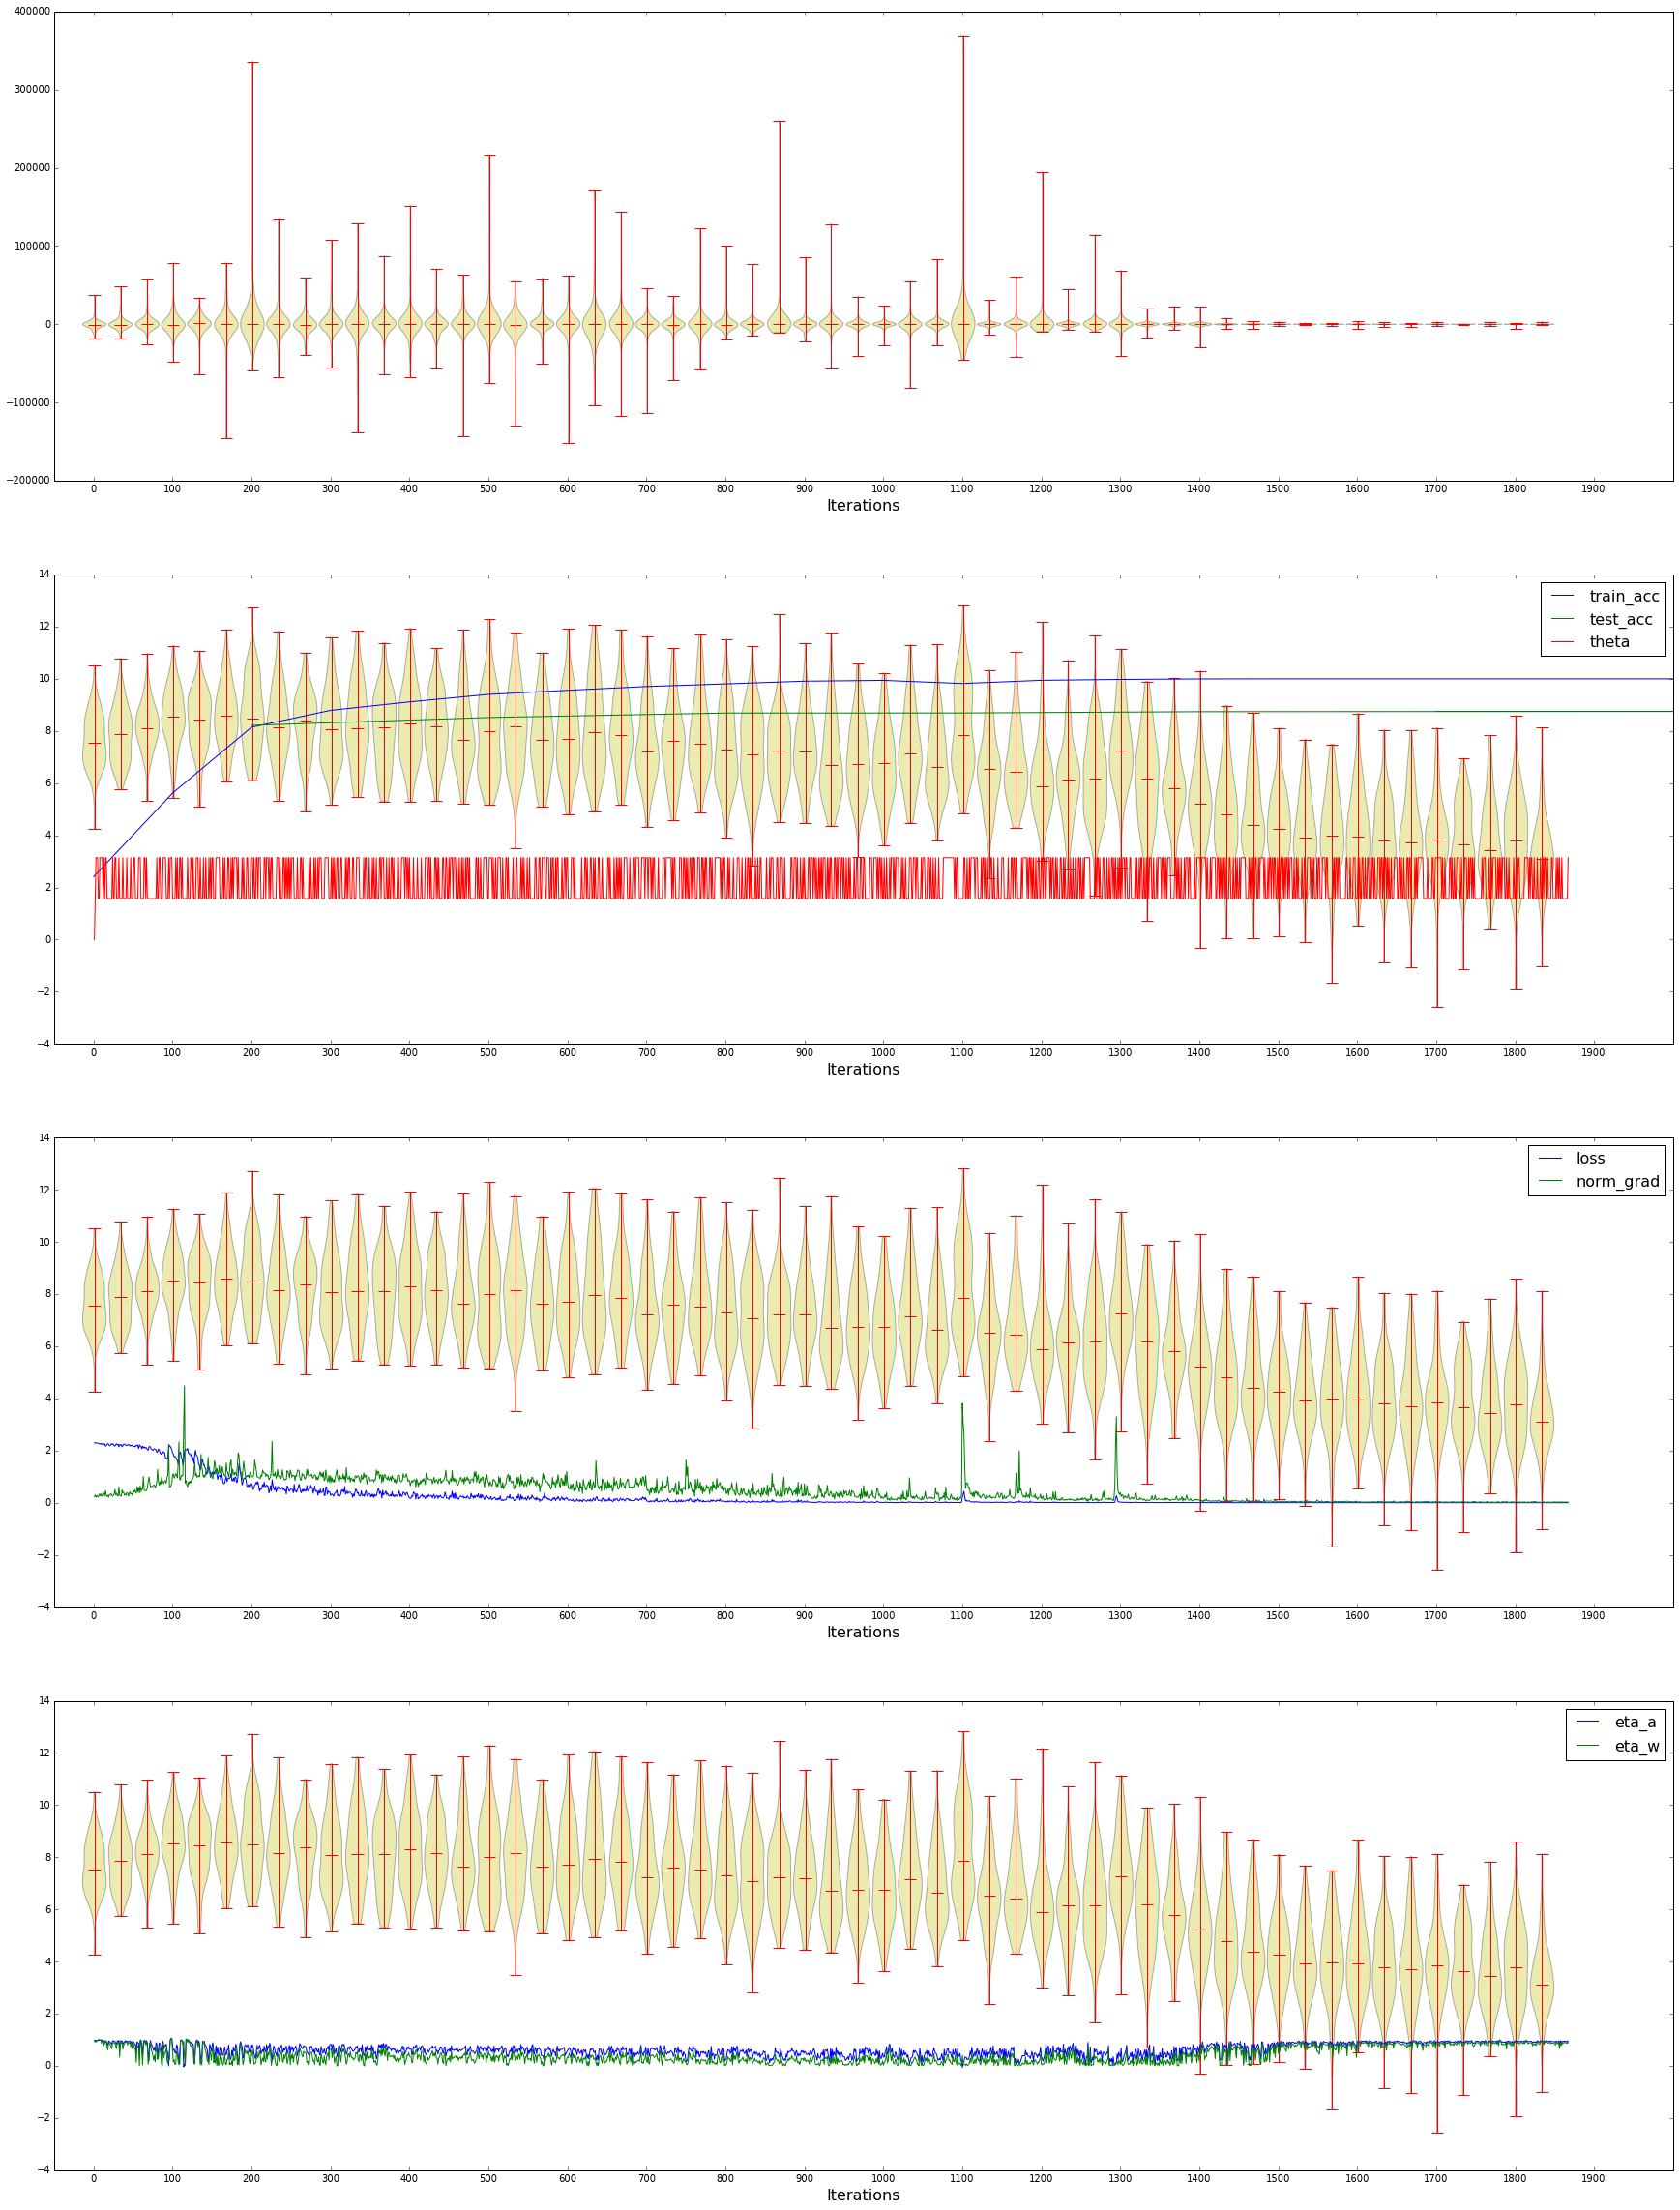

In [2]:
sgu_eig_iters, sgu_eig_dists, sgu_log_eig_dists, sgu_loss_dists = \
    make_violin_plots("../logs/sgu_train_scores.csv", "../logs/sgu_test_scores.csv",
        "../logs/sgu_output_truncated.log")

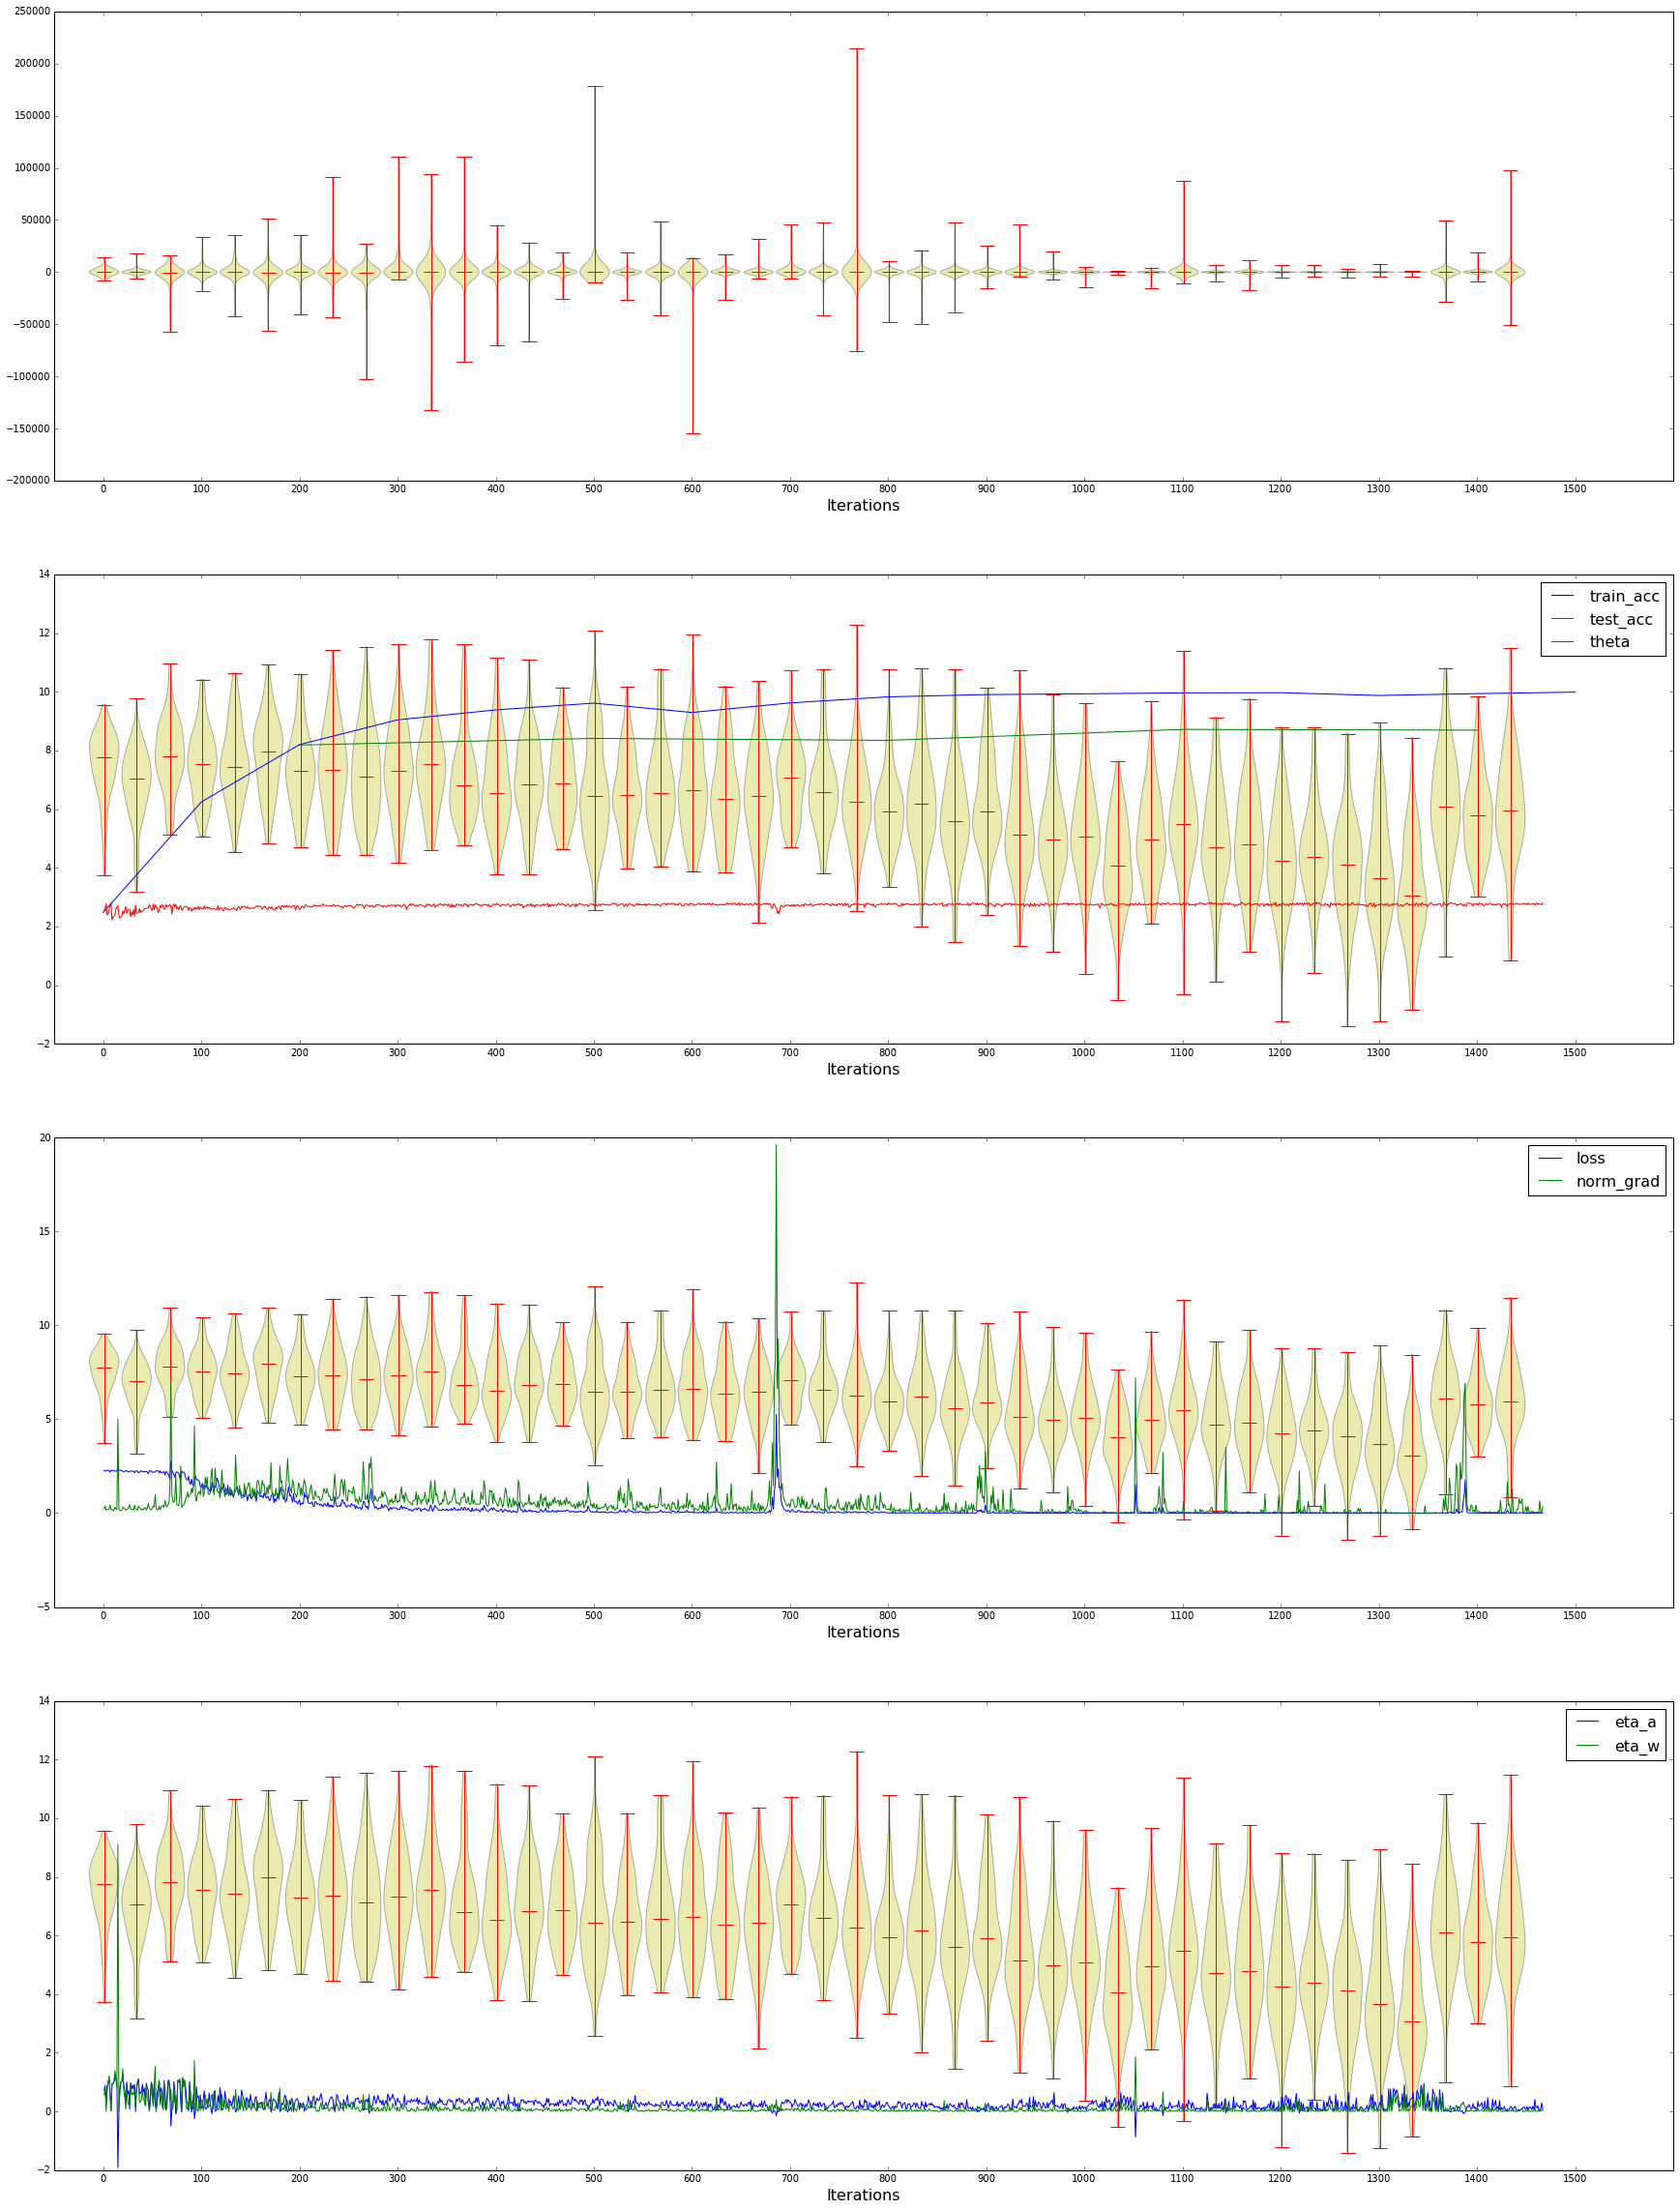

In [3]:
ada_eig_iters, ada_eig_dists, ada_log_eig_dists, ada_loss_dists = \
    make_violin_plots("../logs/adadelta_train_scores.csv", "../logs/adadelta_test_scores.csv",
        "../logs/adadelta_output_truncated.log")

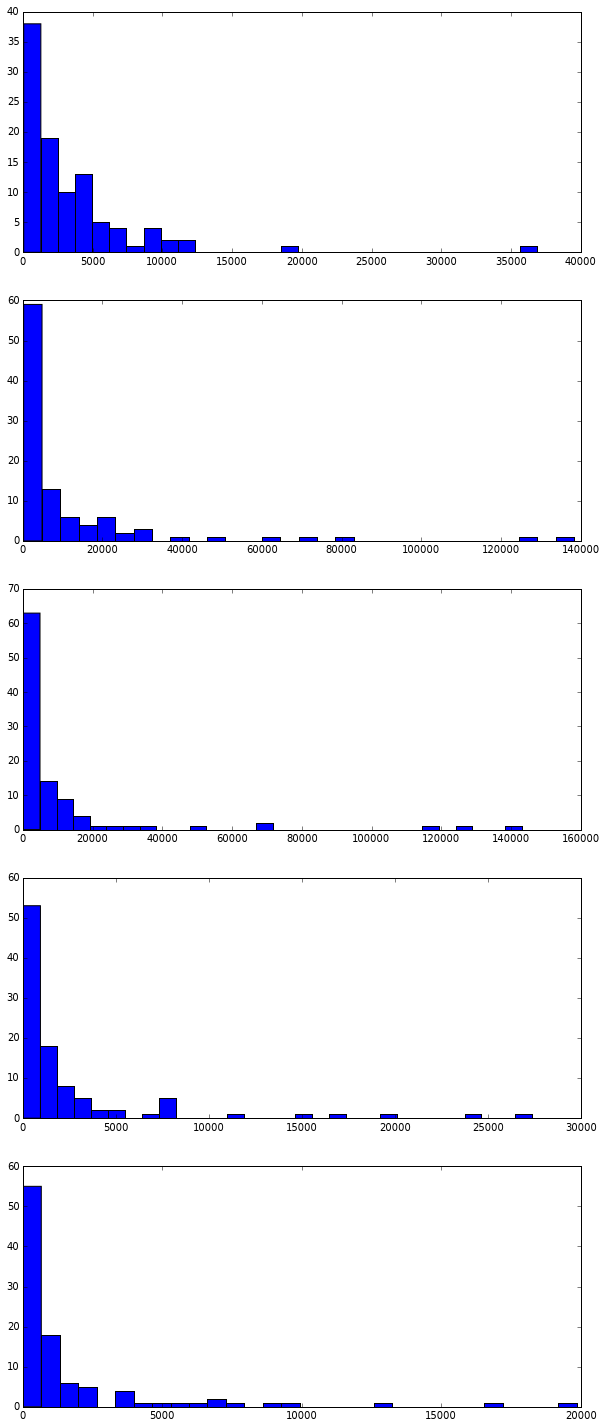

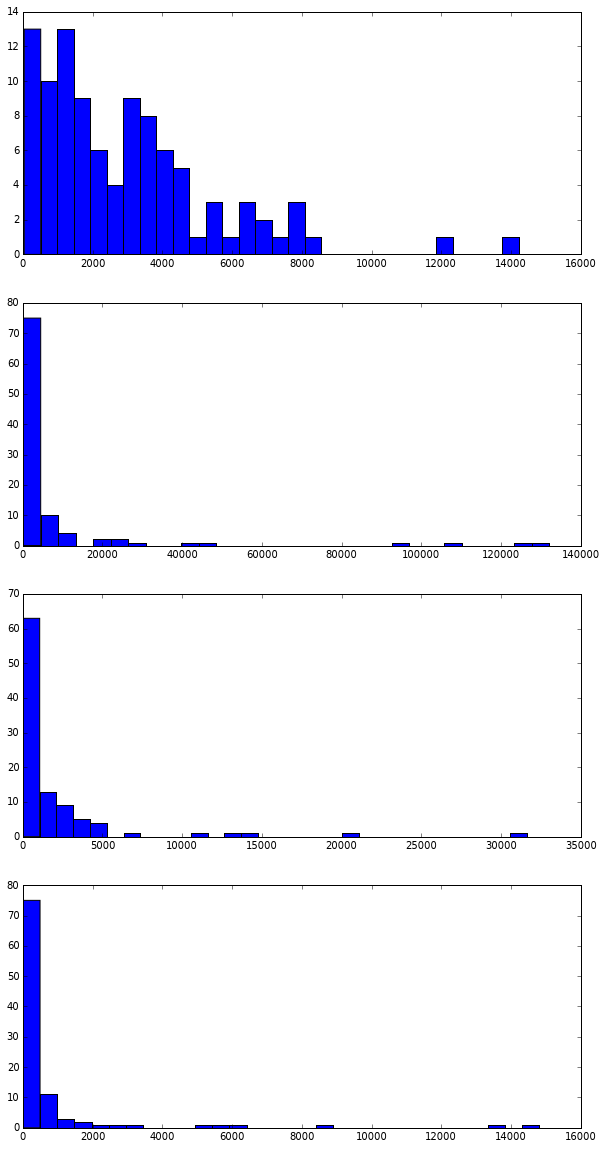

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def make_eig_hists(eig_dists):
    plots = math.floor(len(eig_dists) / 10)
    fig, axes = plt.subplots(nrows=plots, ncols=1, figsize=(10, plots * 5))
    for i in range(0, plots):
        axes[i].hist(np.abs(eig_dists[10 * i]), 30)
    
make_eig_hists(sgu_eig_dists)
make_eig_hists(ada_eig_dists)

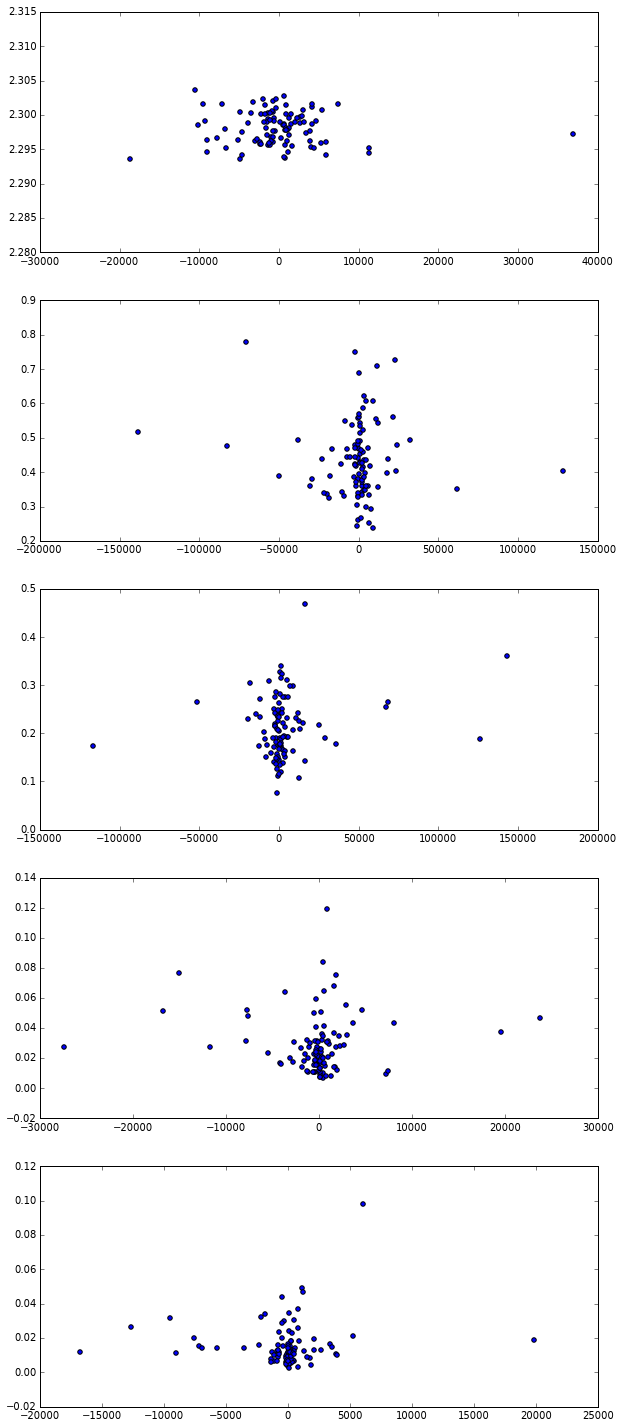

In [7]:
# There seems to be a negative correlation between the loss and maximum eigenvalue.

import numpy as np
import matplotlib.pyplot as plt

def make_eig_scatterplots(eig_dists, loss_dists):
    plots = math.floor(len(eig_dists) / 10)
    fig, axes = plt.subplots(nrows=plots, ncols=1, figsize=(10, plots * 5))
    for i in range(0, plots):
        axes[i].scatter(sgu_eig_dists[10 * i], loss_dists[10 * i])
        #axes[i].set_ylim(-1000, 2000)
    
make_eig_scatterplots(sgu_eig_dists, sgu_loss_dists)
#make_eig_scatterplots(ada_eig_dists, ada_loss_dists)

In [256]:
# Used to write scatterplot data to CSV files to check if there is a
# statistically significant relationship.

import csv

def write_csv(num, eig_dist, loss_dist):
    name = "../eig_loss_scatter_" + str(num) + ".csv"
    writer = csv.writer(open(name, "w"), delimiter=',', quoting=csv.QUOTE_NONE)
    writer.writerow(["max_eig", "loss"])
    
    for x, y in zip(eig_dist, loss_dist):
        writer.writerow([x, y])

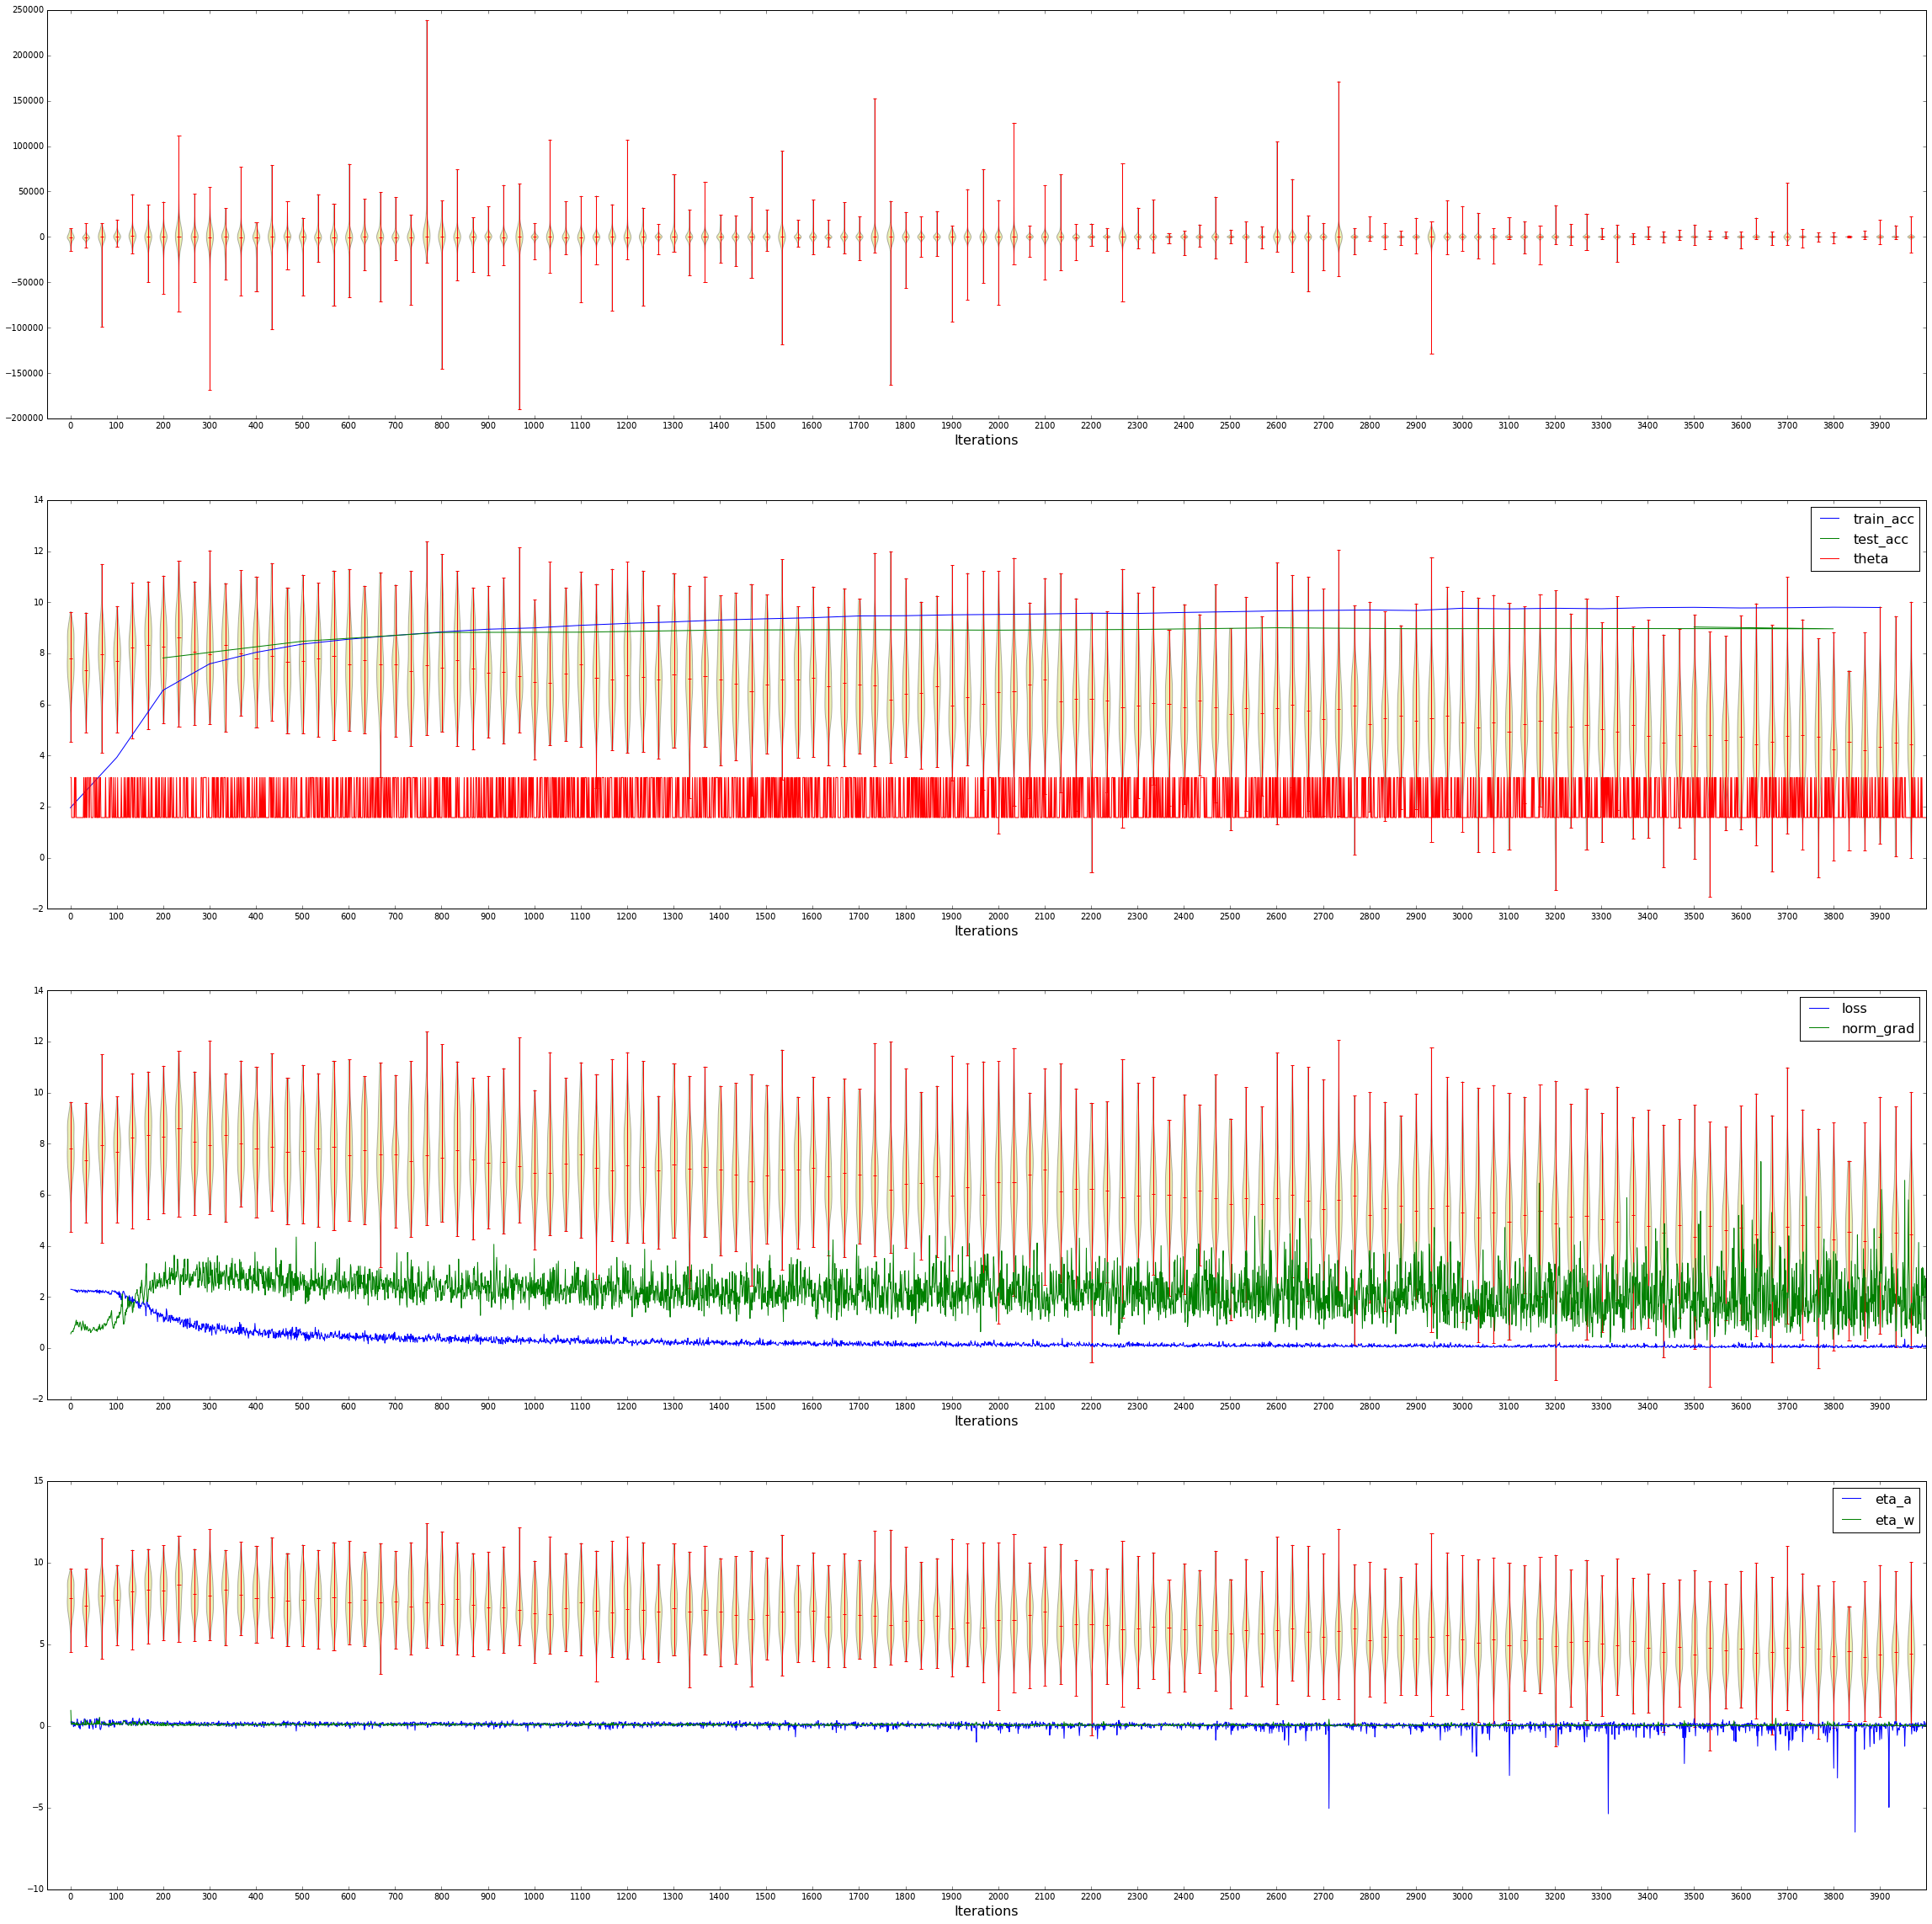

In [12]:
sgu_dp_eig_iters, sgu_dp_eig_dists, sgu_dp_log_eig_dists, sgu_dp_loss_dists = \
    make_violin_plots("../logs/sgu_dropout_train_scores.csv", "../logs/sgu_dropout_test_scores.csv",
        "../logs/sgu_dropout_output.log", 40, 15)

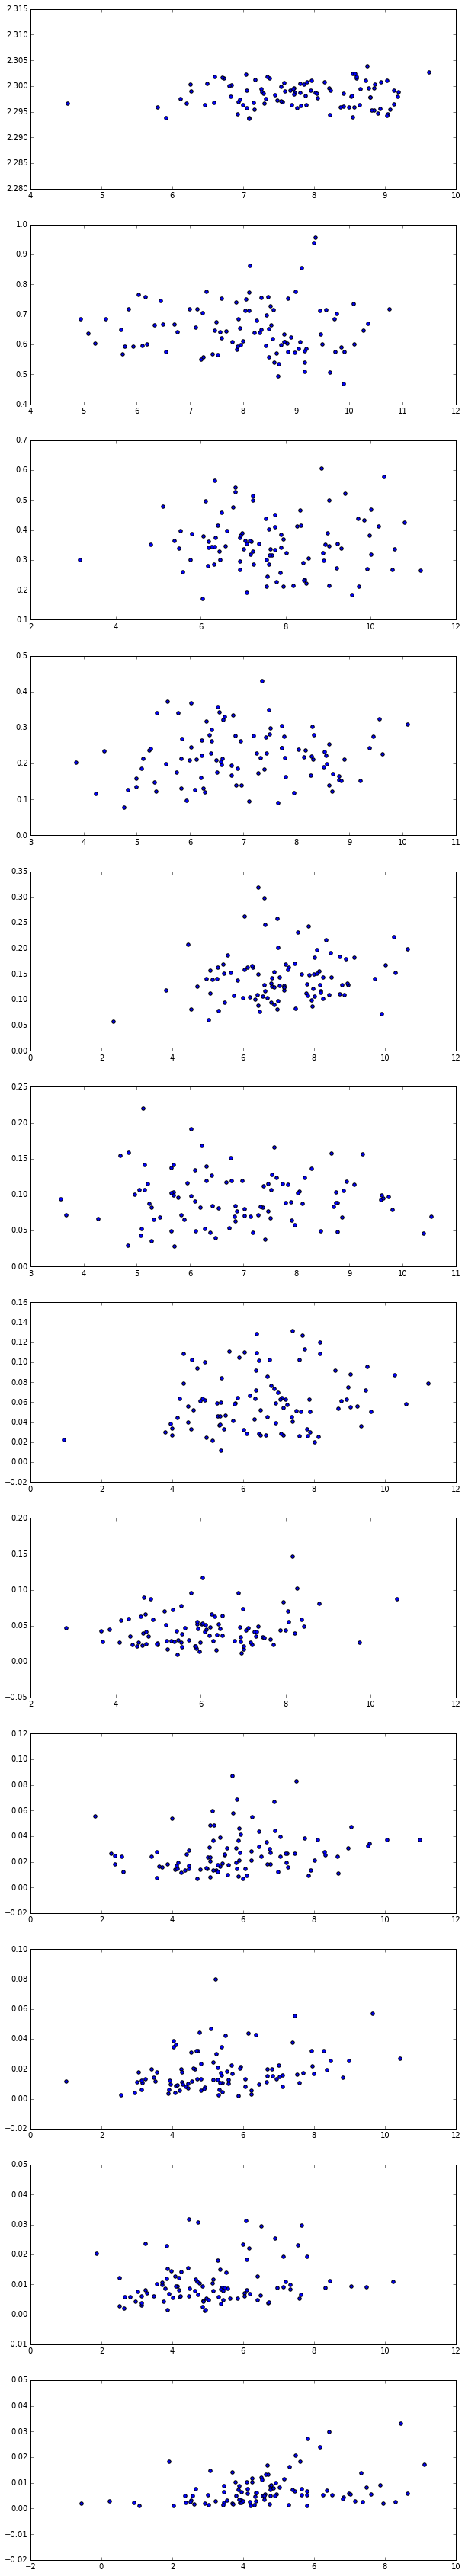

In [15]:
make_eig_scatterplots(sgu_dp_eig_dists, sgu_dp_loss_dists)

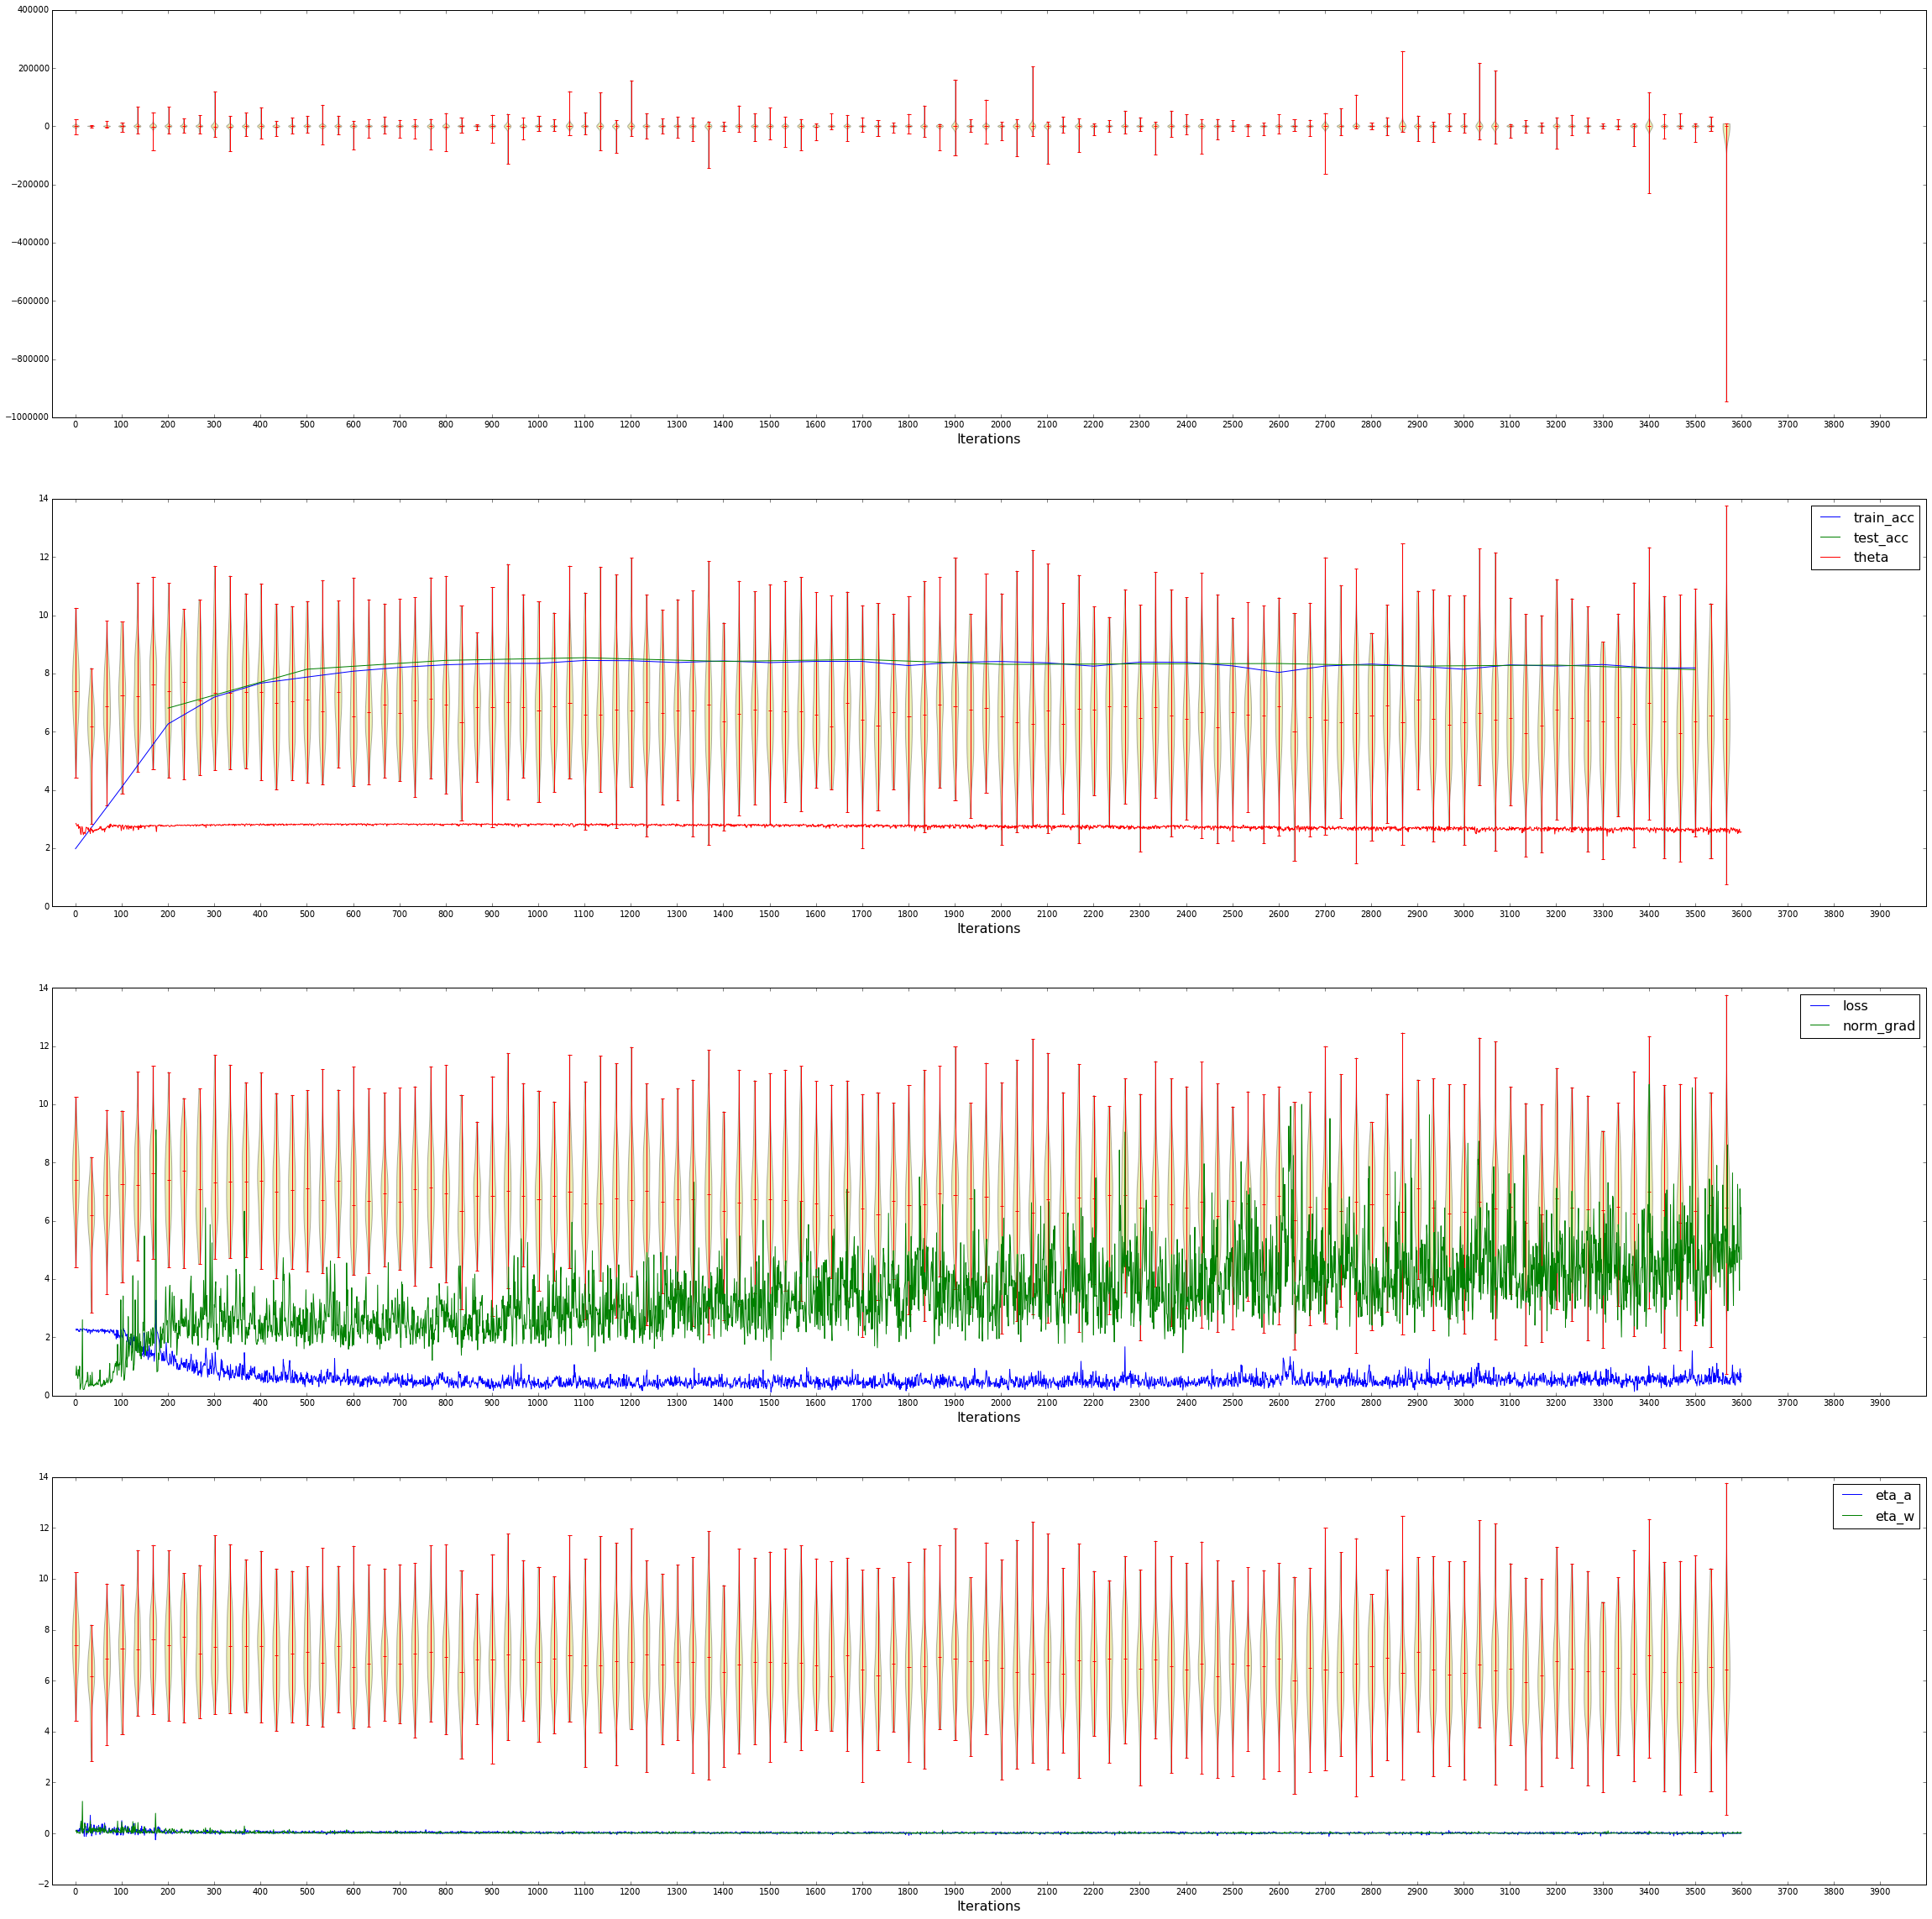

In [16]:
ada_dp_eig_iters, ada_dp_eig_dists, ada_dp_log_eig_dists, ada_dp_loss_dists = \
    make_violin_plots("../logs/adadelta_dropout_train_scores.csv", "../logs/adadelta_dropout_test_scores.csv",
        "../logs/adadelta_dropout_output.log", 40, 15)